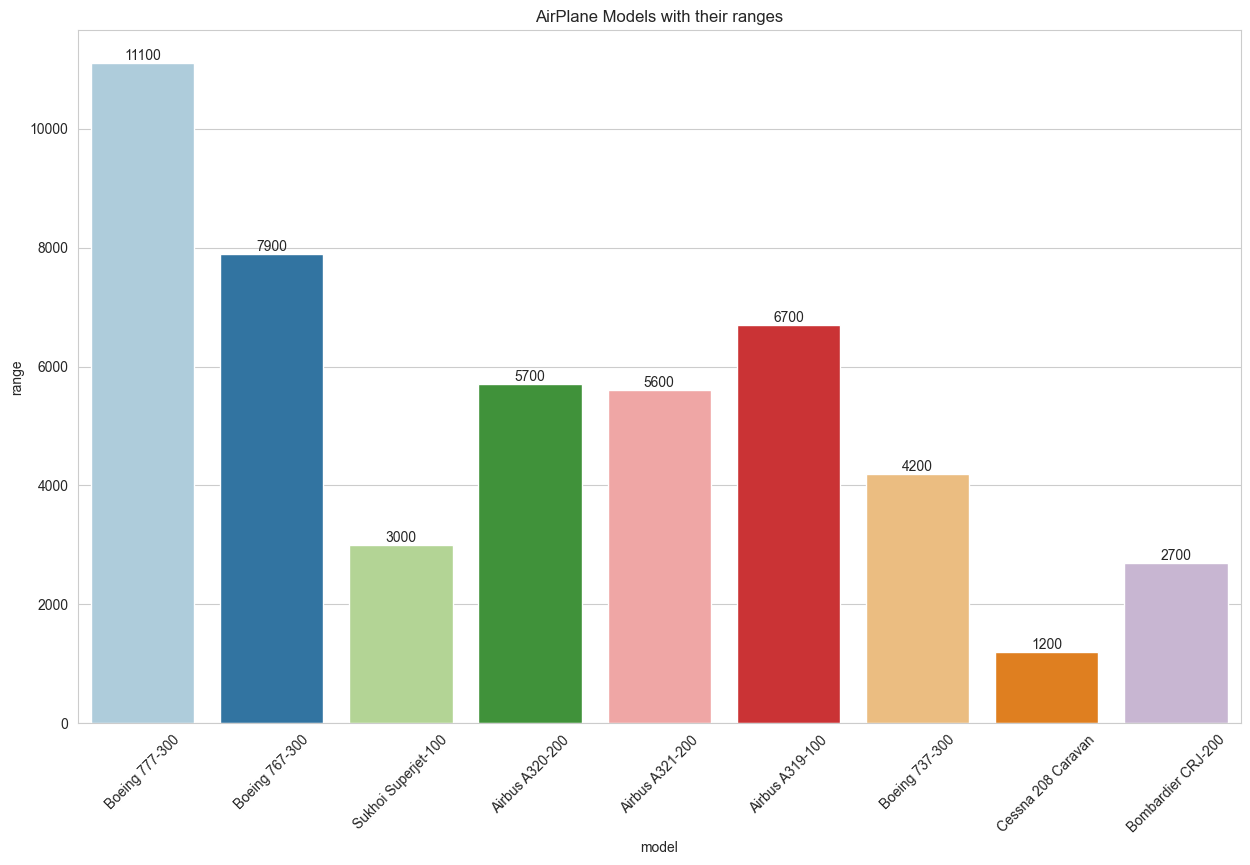

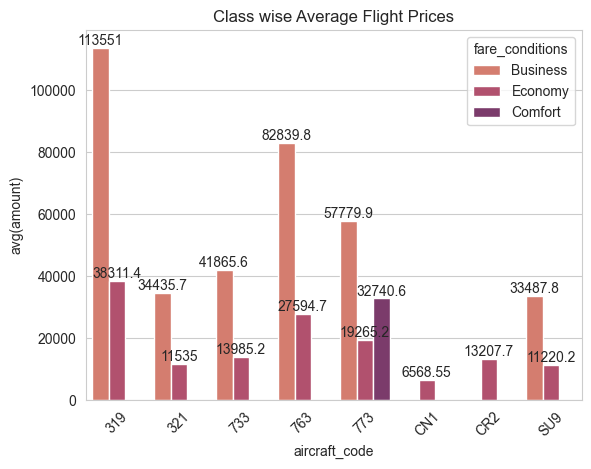

,aircraft_code,booked_seats,num_seats,occupancy_rate,inc occupancy rate,inc Total annual turnover
0,319,53.58318098720292,116,0.46192397402761143,0.5081163714303726,2976779410.0
1,321,88.80923076923077,170,0.5224072398190045,0.574647963800905,1801980510.0
2,733,80.25546218487395,130,0.617349709114415,0.6790846800258565,1569207310.0000002
3,763,113.93729372937294,222,0.5132310528350132,0.5645541581185146,4808404810.0
4,773,264.9258064516129,402,0.659019419033863,0.7249213609372492,3774326050.0
5,CN1,6.004431314623338,12,0.5003692762186115,0.5504062038404727,106011180.00000001
6,CR2,21.48284690220174,50,0.42965693804403476,0.4726226318484382,2181036550.0
7,SU9,56.81211267605634,97,0.5856918832583128,0.644261071584144,5625933169.999999


In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')


#database connection
connection = sqlite3.connect('travel.sqlite')
cursor = connection.cursor()

#list of tables
tables = pd.read_sql("""select * from sqlite_master where type = 'table';""", connection)
tables

#data exploration
aircrafts_data = pd.read_sql_query("select * from aircrafts_data", connection)
aircrafts_data

#change the data in multiple languages
aircrafts_data['model'] = aircrafts_data['model'].apply(lambda x:json.loads(x)['en'])
aircrafts_data

airports_data = pd.read_sql_query("select  * from airports_data", connection)
airports_data

#change airport name and city to 'en'
airports_data['airport_name'] = airports_data['airport_name'].apply(lambda x:json.loads(x)['en'])
airports_data
airports_data['city'] = airports_data['city'].apply(lambda x:json.loads(x)['en'])
airports_data

boarding_passes = pd.read_sql_query("select * from boarding_passes", connection)
boarding_passes


bookings = pd.read_sql_query("select * from bookings",connection)
bookings


flights = pd.read_sql_query("select * from flights", connection)
flights

seats = pd.read_sql_query("select * from seats", connection)
seats


ticket_flights = pd.read_sql_query("select * from ticket_flights", connection)
ticket_flights

tickets = pd.read_sql_query("select * from tickets", connection)
tickets


#chart visualizations
sns.set_style('whitegrid')
fig, axes = plt.subplots(figsize = (15,9))
ax = sns.barplot(x='model', y='range', data=aircrafts_data, palette = 'Paired')
#palette = paired
for container in ax.containers:
    ax.bar_label(container)
plt.title('AirPlane Models with their ranges')
plt.xticks(rotation=45)
plt.show()  

#create a dataframe

# df = pd.read_sql_query("""select aircraft_code, count(*) as num_seats from seats group by aircraft_code having num_seats >100""", connection)
# df

# sns.set_style('white')
# fig, axes = plt.subplots(figsize = (15,9))
# ax = sns.barplot(x='aircraft_code', y='num_seats', data=df, palette='flare')
# for container in ax.containers:
#     ax.bar_label(container)
# plt.title('AirCraft codes Vs Number of seats')
# plt.xticks(rotation=45)
# plt.show()

#air craft code to derive the names of aircraft
# crafts = pd.read_sql_query("""select aircraft_code, model->'en' from aircrafts_data where aircraft_code in (319, 320, 321, 733, 763, 773);""", connection)
# crafts

#tickets

# tickets = pd.read_sql_query("""select * from tickets inner join bookings on tickets.book_ref = bookings.book_ref""", connection)
# tickets['book_date'] = pd.to_datetime(tickets['book_date'])
# tickets['date'] = tickets['book_date'].dt.date
# tickets_count= tickets.groupby('date')[['date']].count()
# plt.figure(figsize=(18,6))
# plt.plot(tickets_count.index, tickets_count['date'], color='green',scalex=True, marker ="*")
# plt.title('Number of Tickets Booked on Each Date', fontsize= 30)
# plt.xlabel('Date', fontsize=20)
# plt.ylabel('Number of Tickets', fontsize=20)
# plt.grid('b')
# plt.show()

#bookings
# bookings = pd.read_sql_query("select * from bookings", connection)
# bookings['book_date']= pd.to_datetime(bookings['book_date'])
# bookings['date'] = bookings['book_date'].dt.date
# booking_amount = bookings.groupby('date')[['total_amount']].sum()

# plt.figure(figsize=(18,6))
# plt.plot(booking_amount.index, booking_amount['total_amount'], color = 'red', scalex=True, marker ='*')
# plt.title('Number of Tickets Booked on Each date', fontsize=30)
# plt.xlabel('Date', fontsize=20)
# plt.ylabel('Total Amount Earned', fontsize=20)
# plt.grid('b')
# plt.show()

df = pd.read_sql_query("""select fare_conditions, aircraft_code, avg(amount) from ticket_flights join flights on ticket_flights.flight_id
                       = flights.flight_id group by aircraft_code, fare_conditions""", connection)


ax = sns.barplot(x='aircraft_code', y='avg(amount)', hue='fare_conditions', data = df, palette= 'flare')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Class wise Average Flight Prices')
plt.xticks(rotation=45)
plt.show()

crafts = pd.read_sql_query("""select aircraft_code, model->'en' from aircrafts_data where aircraft_code in (319, 321, 733,763,773,'CN1','CR2','SU9');""", connection)
crafts

#occupancy rate
revenue = pd.read_sql_query("""select aircraft_code, ticket_count, total_revenue,total_revenue/ticket_count as avg_revenue_per_ticket from(select aircraft_code, count(*) as ticket_count, sum(amount) as total_revenue from ticket_flights
                            join flights on ticket_flights.flight_id = flights.flight_id group by aircraft_code)""", connection)
revenue.to_csv('revenue.csv')

#calcualte the avarage occupancy per aircraft

occupancy_rate = pd.read_sql_query("""select a.aircraft_code, avg(a.seats_count) as booked_seats, b.num_seats, avg(a.seats_count)/b.num_seats as occupancy_rate from
                                   (select aircraft_code, flights.flight_id, count(*) as seats_count from boarding_passes inner join flights
                                   on boarding_passes.flight_id = flights.flight_id group by aircraft_code, flights.flight_id)as a inner join(select aircraft_code,count(*) as num_seats from seats
                                   group by aircraft_code) as b on a.aircraft_code = b.aircraft_code group by a.aircraft_code""", connection)
occupancy_rate

#calc how much the total annual turnover would increase by giving all aircraft a 10% higher occupancy rate
occupancy_rate['inc occupancy rate'] = occupancy_rate['occupancy_rate'] + occupancy_rate['occupancy_rate']*0.1
occupancy_rate

pd.set_option("display.float_format", str)
total_revenue = pd.read_sql_query("""select aircraft_code, sum(amount) as total_revenue from ticket_flights join flights on ticket_flights.flight_id = flights.flight_id
                                  group by aircraft_code""", connection)
total_revenue

occupancy_rate['inc Total annual turnover'] = (total_revenue['total_revenue']/occupancy_rate['occupancy_rate'])*occupancy_rate['inc occupancy rate']
occupancy_rate



# cursor.execute('''select name from sqlite_master where type = 'table';''')